# TRAINING

In [1]:
# download dataset from huggingface
!wget https://huggingface.co/datasets/miladfa7/Intel-Image-Classification/resolve/main/archive.zip

--2023-10-04 18:01:17--  https://huggingface.co/datasets/miladfa7/Intel-Image-Classification/resolve/main/archive.zip
Resolving huggingface.co (huggingface.co)... 18.172.134.88, 18.172.134.124, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.88|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/ba/78/ba78f7bc84cf1a0be6a5b04c6a3945154cdc9a52715d74d3fc4b62c39ceb017e/3921405607c3e9d67a3459b6c629894c3a723aa1647f9310b6793da306e89337?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27archive.zip%3B+filename%3D%22archive.zip%22%3B&response-content-type=application%2Fzip&Expires=1696701677&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5NjcwMTY3N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9iYS83OC9iYTc4ZjdiYzg0Y2YxYTBiZTZhNWIwNGM2YTM5NDUxNTRjZGM5YTUyNzE1ZDc0ZDNmYzRiNjJjMzljZWIwMTdlLzM5MjE0MDU2MDdjM2U5ZDY3YTM0NTliNmM2Mjk4

In [2]:
# unzip the dataset
!unzip -q "/content/archive.zip"

In [3]:
# create image paths for training, testing and prediction
base_path = "/content/"
seg_pred_path = base_path + "seg_pred/seg_pred"
seg_test_path = base_path + "seg_test/seg_test"
seg_train_path = base_path + "seg_train/seg_train"

In [4]:
# import libraries required for training
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [5]:
# check the pytorch version
print(torch.__version__)

2.0.1+cu118


In [6]:
# checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
# create transformer for data augmentation with random horizontal flip and normalization
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [8]:

# path for training and testing directory
train_path=seg_train_path
test_path=seg_test_path

# dataloader for training and testing dataset with batch size 256
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=256, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=256, shuffle=True
)

In [9]:
# list of all the classes in the dataset
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [19]:
# create the model

class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()

        # input shape=(256,3,150,150)
        # 256 : batch size
        # 3 : no of channels (R G B)
        # 150: width and height of image

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        # feed forward function
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        
        # above output will be in matrix form, with shape (256,32,75,75)
        # references for .view()
        # 1. https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view
        # 2. https://github.com/torch/cutorch/issues/98
        # 3. https://stackoverflow.com/a/65970435
    
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        
        return output



In [20]:
# calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)


14034 3000


Model1-(SGD,10_epochs) Evaluation Metrics:
Accuracy: 0.6253
Precision: 0.6664
Recall: 0.6253
F1 Score: 0.6264

Model1-(SGD,10_epochs): Epoch: 0 Train Loss: tensor(2.0918) Train Accuracy: 0.473564201225595 Test Accuracy: 0.6253333333333333
Saved the model at epoch :0
Model1-(SGD,10_epochs) Evaluation Metrics:
Accuracy: 0.6017
Precision: 0.7019
Recall: 0.6017
F1 Score: 0.5803

Model1-(SGD,10_epochs): Epoch: 1 Train Loss: tensor(1.2242) Train Accuracy: 0.5979050876442924 Test Accuracy: 0.6016666666666667
Model1-(SGD,10_epochs) Evaluation Metrics:
Accuracy: 0.6813
Precision: 0.6969
Recall: 0.6813
F1 Score: 0.6828

Model1-(SGD,10_epochs): Epoch: 2 Train Loss: tensor(1.0734) Train Accuracy: 0.6351004702864472 Test Accuracy: 0.6813333333333333
Saved the model at epoch :2
Model1-(SGD,10_epochs) Evaluation Metrics:
Accuracy: 0.5657
Precision: 0.7096
Recall: 0.5657
F1 Score: 0.5471

Model1-(SGD,10_epochs): Epoch: 3 Train Loss: tensor(0.9466) Train Accuracy: 0.668946843380362 Test Accuracy: 0.565

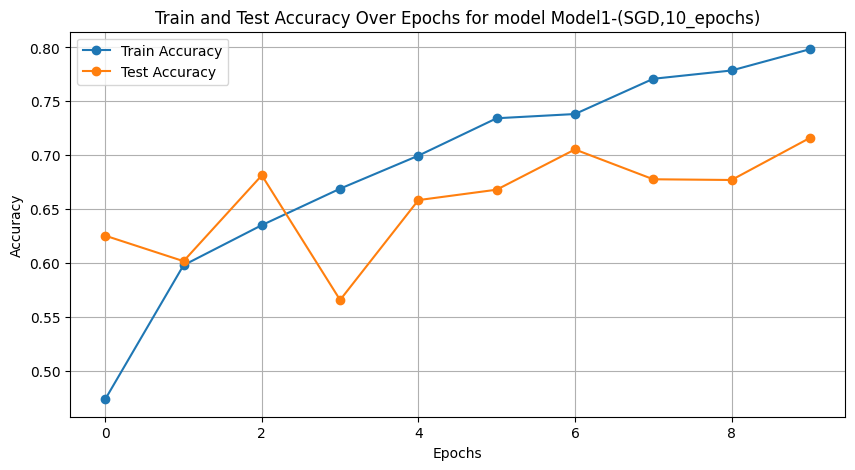

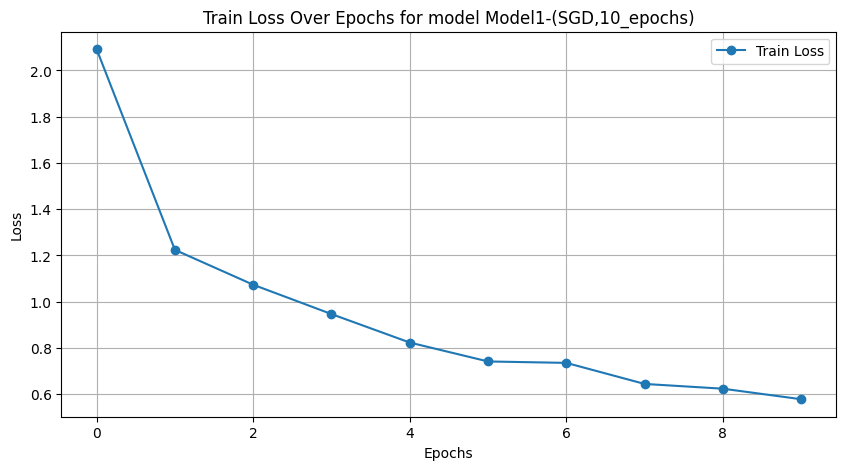

Model2-(Adam,10_epochs) Evaluation Metrics:
Accuracy: 0.5070
Precision: 0.6598
Recall: 0.5070
F1 Score: 0.4927

Model2-(Adam,10_epochs): Epoch: 0 Train Loss: tensor(9.8422) Train Accuracy: 0.5382642154766994 Test Accuracy: 0.507
Saved the model at epoch :0
Model2-(Adam,10_epochs) Evaluation Metrics:
Accuracy: 0.6683
Precision: 0.7115
Recall: 0.6683
F1 Score: 0.6697

Model2-(Adam,10_epochs): Epoch: 1 Train Loss: tensor(1.1459) Train Accuracy: 0.7424825423970358 Test Accuracy: 0.6683333333333333
Saved the model at epoch :1
Model2-(Adam,10_epochs) Evaluation Metrics:
Accuracy: 0.7100
Precision: 0.7366
Recall: 0.7100
F1 Score: 0.7123

Model2-(Adam,10_epochs): Epoch: 2 Train Loss: tensor(0.8141) Train Accuracy: 0.798061849793359 Test Accuracy: 0.71
Saved the model at epoch :2
Model2-(Adam,10_epochs) Evaluation Metrics:
Accuracy: 0.6647
Precision: 0.7222
Recall: 0.6647
F1 Score: 0.6592

Model2-(Adam,10_epochs): Epoch: 3 Train Loss: tensor(0.4773) Train Accuracy: 0.8632606527005843 Test Accur

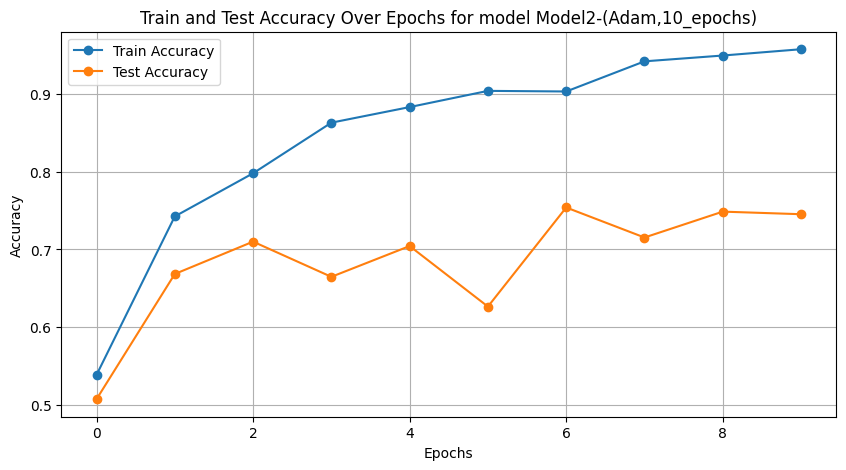

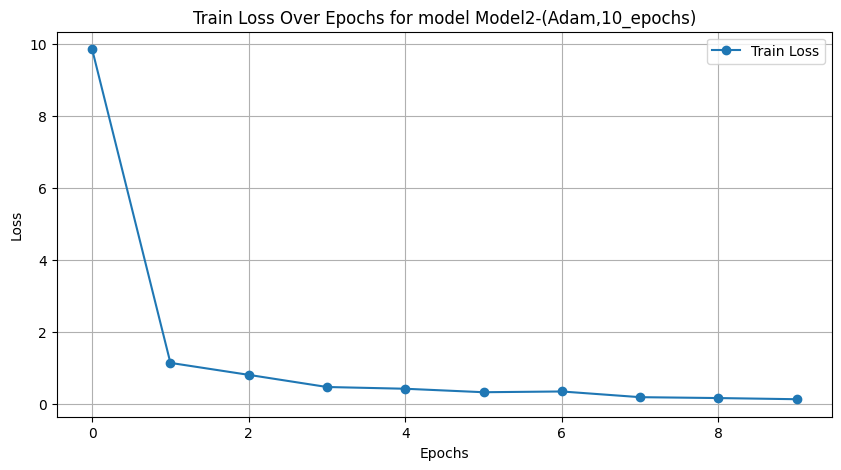

Model3-(RMSprop,10_epochs) Evaluation Metrics:
Accuracy: 0.5393
Precision: 0.6832
Recall: 0.5393
F1 Score: 0.4832

Model3-(RMSprop,10_epochs): Epoch: 0 Train Loss: tensor(62.7823) Train Accuracy: 0.5019951546244834 Test Accuracy: 0.5393333333333333
Saved the model at epoch :0
Model3-(RMSprop,10_epochs) Evaluation Metrics:
Accuracy: 0.6890
Precision: 0.7036
Recall: 0.6890
F1 Score: 0.6888

Model3-(RMSprop,10_epochs): Epoch: 1 Train Loss: tensor(11.0570) Train Accuracy: 0.6110873592703434 Test Accuracy: 0.689
Saved the model at epoch :1
Model3-(RMSprop,10_epochs) Evaluation Metrics:
Accuracy: 0.5480
Precision: 0.6559
Recall: 0.5480
F1 Score: 0.5336

Model3-(RMSprop,10_epochs): Epoch: 2 Train Loss: tensor(6.2323) Train Accuracy: 0.6418697449052302 Test Accuracy: 0.548
Model3-(RMSprop,10_epochs) Evaluation Metrics:
Accuracy: 0.6193
Precision: 0.6329
Recall: 0.6193
F1 Score: 0.6100

Model3-(RMSprop,10_epochs): Epoch: 3 Train Loss: tensor(4.1384) Train Accuracy: 0.6597548810032777 Test Accur

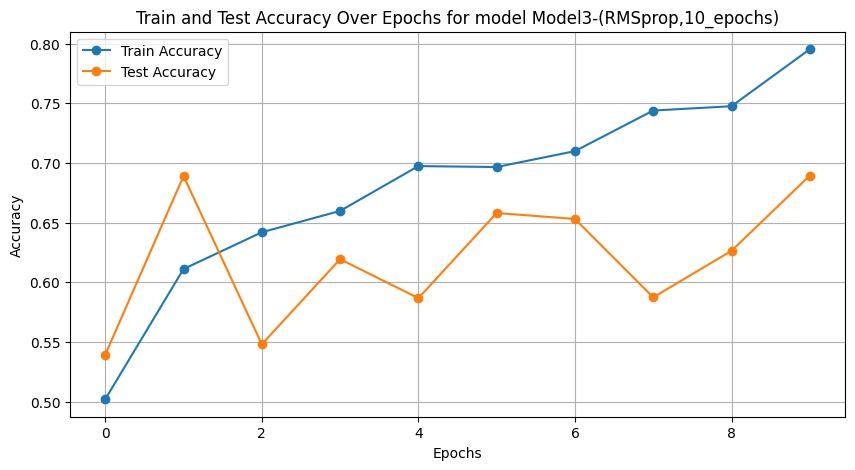

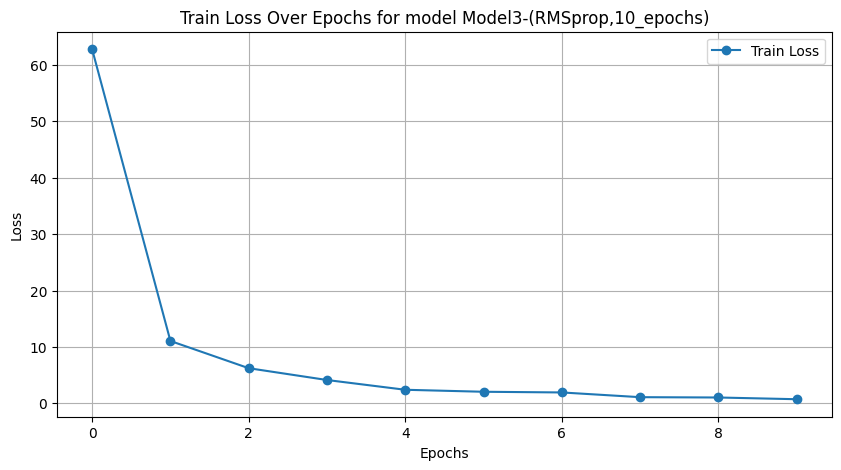

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model4-(AdaGrad,10_epochs) Evaluation Metrics:
Accuracy: 0.5210
Precision: 0.5488
Recall: 0.5210
F1 Score: 0.4606

Model4-(AdaGrad,10_epochs): Epoch: 0 Train Loss: tensor(7.2586) Train Accuracy: 0.5118996722245974 Test Accuracy: 0.521
Saved the model at epoch :0
Model4-(AdaGrad,10_epochs) Evaluation Metrics:
Accuracy: 0.5853
Precision: 0.6941
Recall: 0.5853
F1 Score: 0.5304

Model4-(AdaGrad,10_epochs): Epoch: 1 Train Loss: tensor(1.6383) Train Accuracy: 0.6276186404446344 Test Accuracy: 0.5853333333333334
Saved the model at epoch :1
Model4-(AdaGrad,10_epochs) Evaluation Metrics:
Accuracy: 0.7407
Precision: 0.7542
Recall: 0.7407
F1 Score: 0.7397

Model4-(AdaGrad,10_epochs): Epoch: 2 Train Loss: tensor(1.0809) Train Accuracy: 0.6895396893259228 Test Accuracy: 0.7406666666666667
Saved the model at epoch :2
Model4-(AdaGrad,10_epochs) Evaluation Metrics:
Accuracy: 0.7260
Precision: 0.7437
Recall: 0.7260
F1 Score: 0.7199

Model4-(AdaGrad,10_epochs): Epoch: 3 Train Loss: tensor(0.7322) Train 

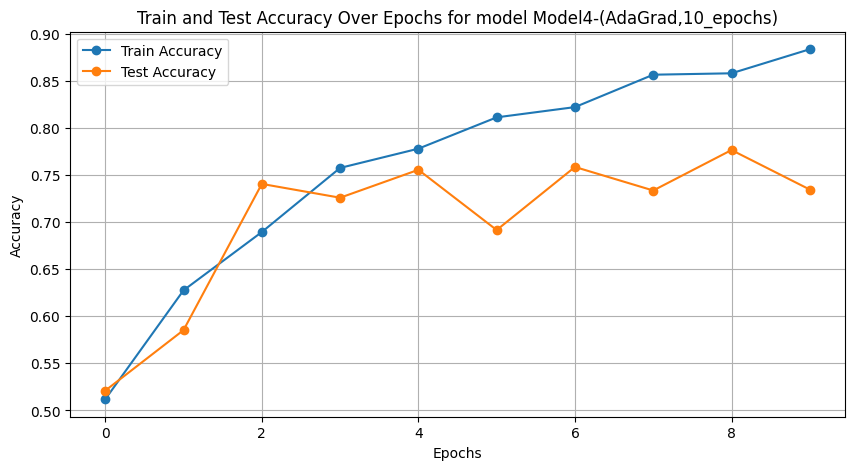

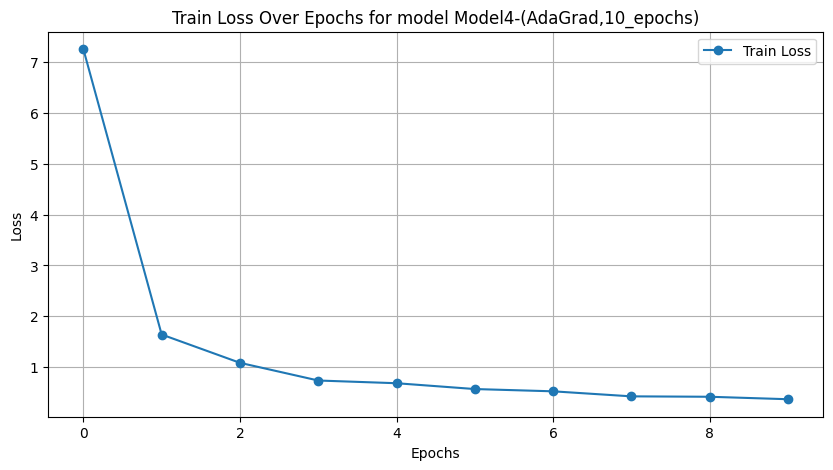

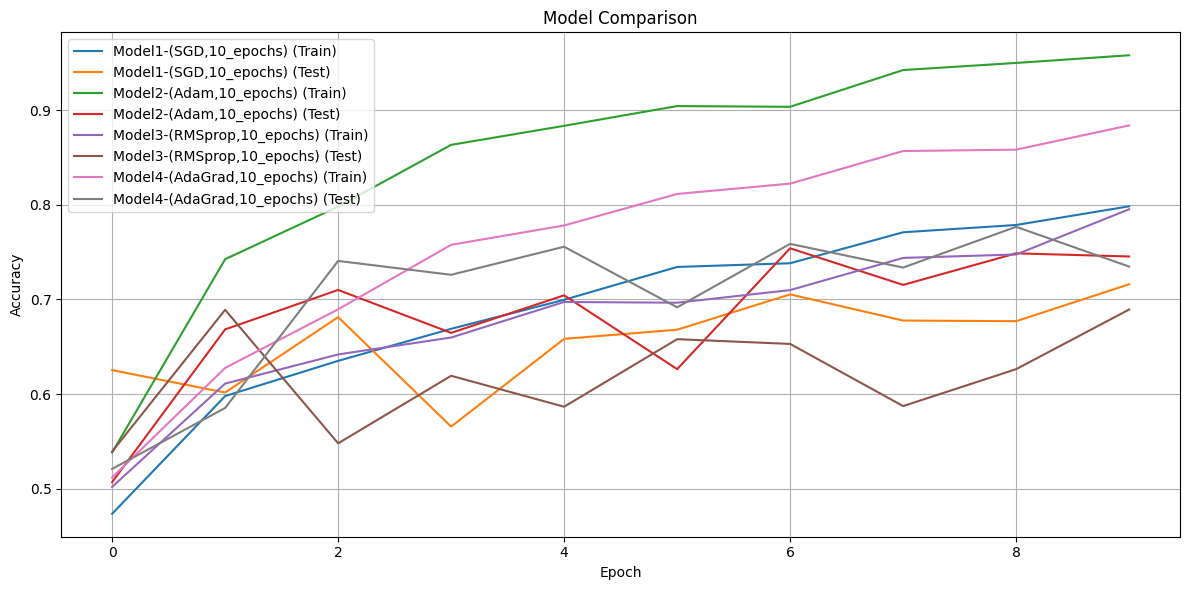

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the models to compare
number_of_epochs = 10
models_to_compare = [
    ("Model1-(SGD,"+str(number_of_epochs)+"_epochs)", ConvNet(num_classes=6).to(device), torch.optim.SGD, number_of_epochs),
    ("Model2-(Adam,"+str(number_of_epochs)+"_epochs)", ConvNet(num_classes=6).to(device), torch.optim.Adam, number_of_epochs),
    ("Model3-(RMSprop,"+str(number_of_epochs)+"_epochs)", ConvNet(num_classes=6).to(device), torch.optim.RMSprop, number_of_epochs),
    ("Model4-(AdaGrad,"+str(number_of_epochs)+"_epochs)", ConvNet(num_classes=6).to(device), torch.optim.Adagrad, number_of_epochs),
]

# Define the loss function
loss_function=nn.CrossEntropyLoss()

# Define a dictionary to store the training and testing accuracies for each model
model_accuracies = {model_name: {"train": [], "test": []} for model_name, _, _, _ in models_to_compare}

# Train and evaluate each model
for model_name, model, optimizer_class, num_epochs in models_to_compare:
    optimizer = optimizer_class(model.parameters(), lr=0.001, weight_decay=0.0001)
    best_accuracy = 0.0

    train_losses = []
    train_accuracies = []
    test_accuracies = []
    epochs = []  # To store the epoch numbers

    # evaluation and training on training dataset
    for epoch in range(num_epochs):
        # training block :
        model.train()
        train_accuracy=0.0
        train_loss=0.0

        for i, (images,labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            optimizer.zero_grad()

            outputs=model(images)
            loss=loss_function(outputs,labels)
            loss.backward()
            optimizer.step()


            train_loss+= loss.cpu().data*images.size(0)
            _,prediction=torch.max(outputs.data,1)

            train_accuracy+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_accuracy/train_count
        train_loss=train_loss/train_count


        # evaluation block :
        model.eval()
        y_true = []
        y_pred = []
        test_accuracy=0.0
        for i, (images,labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            outputs=model(images)
            _,prediction=torch.max(outputs.data,1)
            y_true.extend(labels.tolist())
            y_pred.extend(prediction.cpu().numpy().tolist())

            test_accuracy+=int(torch.sum(prediction==labels.data))

        test_accuracy=test_accuracy/test_count

        # Calculate and print evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average="weighted")
        recall = recall_score(y_true, y_pred, average="weighted")
        f1 = f1_score(y_true, y_pred, average="weighted")

        print(
            f"{model_name} Evaluation Metrics:\n"
            f"Accuracy: {accuracy:.4f}\n"
            f"Precision: {precision:.4f}\n"
            f"Recall: {recall:.4f}\n"
            f"F1 Score: {f1:.4f}\n"
        )

        # Append results to lists
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        epochs.append(epoch)

        print(model_name + ': Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

        #Save the best model
        if test_accuracy>best_accuracy:
            print("Saved the model at epoch :"  + str(epoch) )
            torch.save(model.state_dict(),'best_checkpoint_of'+model_name+'.model')
            best_accuracy=test_accuracy

        # Calculate and store training and testing accuracies for this epoch
        # train_accuracy = train_accuracy / train_count
        # test_accuracy = test_accuracy / test_count
        model_accuracies[model_name]["train"].append(train_accuracy)
        model_accuracies[model_name]["test"].append(test_accuracy)

    # Create a graph for train and test accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy Over Epochs for model ' + model_name)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create a graph for train loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss Over Epochs for model ' + model_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# Create a figure to visualize the results
plt.figure(figsize=(12, 6))
plt.title("Model Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Plot training and testing accuracies for each model
for model_name, accuracy_data in model_accuracies.items():
    plt.plot(range(len(accuracy_data["train"])), accuracy_data["train"], label=f"{model_name} (Train)")
    plt.plot(range(len(accuracy_data["test"])), accuracy_data["test"], label=f"{model_name} (Test)")

plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or display the figure
plt.savefig("model_comparison.png")
plt.show()

In [22]:
import IPython
display(IPython.display.Audio(url="https://static.sfdict.com/audio/C07/C0702600.mp3", autoplay=True))

In [23]:
!pip install plotly


In [25]:
import plotly.graph_objects as go

# Create a list to store traces for each model
traces = []

# Create a figure to visualize the results
fig = go.Figure()

# Set the layout for the figure
fig.update_layout(
    title="Model Comparison",
    xaxis_title="Epoch",
    yaxis_title="Accuracy",
)

# Plot training and testing accuracies for each model
for model_name, accuracy_data in model_accuracies.items():
    train_trace = go.Scatter(
        x=list(range(len(accuracy_data["train"]))),
        y=accuracy_data["train"],
        mode="lines",
        name=f"{model_name} (Train)"
    )
    test_trace = go.Scatter(
        x=list(range(len(accuracy_data["test"]))),
        y=accuracy_data["test"],
        mode="lines",
        name=f"{model_name} (Test)"
    )

    traces.extend([train_trace, test_trace])

# Add the traces to the figure
fig.add_traces(traces)

# Display the figure
fig.show()